# Imports

In [1]:
from os.path import join as pjoin
import numpy as np
import pandas as pd
import sys
sys.path.append(pjoin('..', 'scripts'))

pd.options.display.max_rows = 50
pd.options.display.max_columns = 100
pd.options.display.max_colwidth = 100
np.set_printoptions(precision=4)

In [2]:
from os import cpu_count
from os.path import join as pjoin
from pprint import pprint

import numpy as np
import pandas as pd

from tqdm.notebook import tqdm
from utils import lgb_accuracy, np_weighted_accuracy

# Load data

In [3]:
# DATA_DIR = pjoin('..', 'data', 'raw')
DATA_DIR = pjoin('..', 'data')
train = pd.read_pickle(pjoin(DATA_DIR, 'train_df.pkl')).set_index('id')
test = pd.read_pickle(pjoin(DATA_DIR, 'test_df.pkl')).set_index('id')
train_dev_split = pd.read_csv(pjoin(DATA_DIR, 'train_dev.csv')).set_index('id')
train['train_dev'] = train_dev_split['train_dev']

# concat datasets
df = pd.concat([train, test], sort=False)
# add train/test label
df['is_test'] = False
df.loc[df.target.isnull(), 'is_test'] = True

TARGET = 'target'
seed = 42

In [4]:
print(df.shape)
# check train/test merge correctness
print(df.is_test.value_counts())
df.head()

(19891, 10)
False    15515
True      4376
Name: is_test, dtype: int64


html  \
id                                                                                                                                          
b811ea46-1bc5-4a18-a64c-7504c382da44  [b'<!DOCTYPE html>\n<html lang="en" class="preload">\n\n<head prefix="og: http://ogp.me/ns# fb: ...   
b5e3f6d4-30bc-443c-a9d6-8ed41d5c33b3  [b'<!DOCTYPE html>\n<html lang="en-US">\n  <head>    \n  <!-- Global site tag (gtag.js) - Google...   
997ae1ab-93c4-45a9-9bd0-a49b2b952f1f  [b'<!doctype html>\n<html lang="en-US">\n<head>\n\t<meta charset="utf-8">\n\t<meta http-equiv="x...   
6890f2f1-bdc1-48cb-bf7f-00944eb37e77  [b'<?xml version="1.0" encoding="iso-8859-1"?><!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Trans...   
74a95f04-e440-4af0-850a-eec5a44ba397  [b'\r\n\r\n<!DOCTYPE html>\r\n\r\n<html xmlns="http://www.w3.org/1999/xhtml">\r\n<head><title>\r...   

                                                                                                                                     text  \
id                                                                                                                                          
b811ea46-1bc5-4a18-a64c-7504c382da44  [Release\n2020\n2019\n2018\n2017\n2020\n2019\n2018\n2017\nBooks\nOverview Top\nStrategy consulti...   
b5e3f6d4-30bc-443c-a9d6-8ed41d5c33b3  [SAP Integrated Business Planning (IBP)\nSAP Advanced Planning & Optimization (APO)\nPP/DS for S...   
997ae1ab-93c4-45a9-9bd0-a49b2b952f1f  [facebook\ntwitter\nlinkedin\ninstagram\nWelcome\nHow\nLeadership Team\n6th Sense\nLet’s Talk\nA...   
6890f2f1-bdc1-48cb-bf7f-00944eb37e77  [ANDERSON BUSINESS TRAVEL\nSpecialist Independent Business Travel Agent \nTel: 01932 222002 ~ Em...   
74a95f04-e440-4af0-850a-eec5a44ba397  [Amari Ireland Ltd\nStandards\nPeople\nQuality\nService\nCopper, Brass & Bronze\nNickel Alloys\n...   

                                                                                                                                 keywords  \
id                                                                                                                                          
b811ea46-1bc5-4a18-a64c-7504c382da44  [tools, services, projects, incubates, investment, infuse, growing, cultivates, Strategy, delive...   
b5e3f6d4-30bc-443c-a9d6-8ed41d5c33b3  [budgeting, decision, cycles, closing, Simplification, consolidation, financial, capabilities, g...   
997ae1ab-93c4-45a9-9bd0-a49b2b952f1f                                                                                                   []   
6890f2f1-bdc1-48cb-bf7f-00944eb37e77            [provide, service, financial, arranging, travel, personal, protection, agency, corporate]   
74a95f04-e440-4af0-850a-eec5a44ba397  [independent, centre, forms, copper, bronze, sizes, centres, Ireland, semi, aluminium, service, ...   

                                                                                                                        accepted_function  \
id                                                                                                                                          
b811ea46-1bc5-4a18-a64c-7504c382da44  accounting, bookeeping, auditing, finance, HR, training, recruitment, legal, IT support services...   
b5e3f6d4-30bc-443c-a9d6-8ed41d5c33b3  IT consultancy, IT support services, IT management and maintenance, ICT services, IT infrastruct...   
997ae1ab-93c4-45a9-9bd0-a49b2b952f1f  general accounting, auditing, book keeping activities, human resource, recruitment, recruitment ...   
6890f2f1-bdc1-48cb-bf7f-00944eb37e77  insurance brokerage, insurance agents, travel operator, travel agency, ticket booking agents, bu...   
74a95f04-e440-4af0-850a-eec5a44ba397  sales agent and sales representative, product brokerage services, distribution, wholesale, suppl...   

                                                                                                                        rejected_function  \
id                                      

## Explore target

### raw target distribution in train

In [5]:
# target distribution
df[TARGET].value_counts(normalize=True)

1.0    0.744892
2.0    0.190139
0.0    0.064969
Name: target, dtype: float64

### distribution in train/dev

In [6]:
df.groupby('train_dev')[TARGET].value_counts(normalize=True)

train_dev  target
dev        1.0       0.755289
           2.0       0.166199
           0.0       0.078511
train      1.0       0.741373
           2.0       0.198240
           0.0       0.060386
Name: target, dtype: float64

In [7]:
# check sample_submission_acc vs those in public LB (0.64072)
train_ind = df.train_dev == 'train'

print('all train, baseline accuracy')
print(np_weighted_accuracy(train[TARGET], np.ones(len(train))*1))

print('train[train], baseline accuracy')
print(np_weighted_accuracy(train.loc[train_ind, TARGET], np.ones(train_ind.sum())*1))

print('train[dev], baseline accuracy')
print(np_weighted_accuracy(train.loc[~train_ind, TARGET], np.ones(len(train) - train_ind.sum())*1))

all train, baseline accuracy
0.62588681288925
train[train], baseline accuracy
0.6187185025197984
train[dev], baseline accuracy
0.6476502732240437


### target by keywords

In [8]:
# explore target by keywords
kwd_split = ['keywords', TARGET]
kwd_stats = train[kwd_split].explode('keywords')\
    .groupby(kwd_split).size().unstack(level=1).fillna(0)

kwd_stats['total'] = kwd_stats.sum(axis=1)
# check "mean" target (varies from 0 (all rejected by 0) to 2 (all accepted))
kwd_stats['mean_target'] = (
    (kwd_stats.iloc[:, 0:3] / kwd_stats['total'].values.reshape(-1, 1)) *
    np.array([[0, 1, 2]])).sum(axis=1)

# drop insignificant (total cnt in train < THLD)
kwd_thld = 10
print(f'keywords\t\t\t: {len(kwd_stats)}')
kwd_stats = kwd_stats[kwd_stats.total >= kwd_thld]
print(f'keywords (after cleaning)\t: {len(kwd_stats)}')

kwd_stats = kwd_stats.sort_values(by=['mean_target', 'total'],
                                  ascending=[False, False])
kwd_stats.head(10)

keywords			: 32319
keywords (after cleaning)	: 7250


target           0    1     2  total  mean_target
keywords                                         
Matrimonial    0.0  0.0  15.0   15.0     2.000000
jurisdictions  0.0  0.0  15.0   15.0     2.000000
Accountants    0.0  1.0  15.0   16.0     1.937500
nav            0.0  1.0  11.0   12.0     1.916667
Seeking        0.0  1.0  10.0   11.0     1.909091
Transferring   0.0  1.0   9.0   10.0     1.900000
mails          0.0  2.0  12.0   14.0     1.857143
Aspects        0.0  2.0  11.0   13.0     1.846154
ensuing        0.0  2.0  11.0   13.0     1.846154
harmonisation  0.0  2.0  11.0   13.0     1.846154

In [9]:
kwd_stats.tail(10)

target           0    1    2  total  mean_target
keywords                                        
biochemical    6.0  4.0  0.0   10.0     0.400000
fertilizer     6.0  4.0  0.0   10.0     0.400000
spectrometry   6.0  4.0  0.0   10.0     0.400000
insulating    11.0  4.0  1.0   16.0     0.375000
Conveyor       8.0  2.0  1.0   11.0     0.363636
Knives         7.0  4.0  0.0   11.0     0.363636
plating        7.0  4.0  0.0   11.0     0.363636
foams         11.0  5.0  0.0   16.0     0.312500
ventilators    9.0  3.0  0.0   12.0     0.250000
oxides         8.0  2.0  0.0   10.0     0.200000

In [10]:
# potential dummy features about acceptance/rejection counts

df['acc_f_cnt'] = df.accepted_function.str.split(',').apply(len)
df['acc_p_cnt'] = df.accepted_product.str.split(',').apply(len)

df['rej_f_cnt'] = df.rejected_function.str.split(',').apply(len)
df['rej_p_cnt'] = df.rejected_product.str.split(',').apply(len)

df.filter(regex='(acc|rej).*_cnt$').corrwith(df[TARGET])

acc_f_cnt    0.155638
acc_p_cnt   -0.121033
rej_f_cnt    0.105417
rej_p_cnt   -0.180061
dtype: float64

### target by acceptance

In [11]:
# check popular acceptances
acceptance_cnts = train.accepted_function.str.lower().str.split(', ').explode().value_counts()
acceptance_cnts.head(10)

auditing                               3382
recruitment                            3280
it support                             2781
distribution                           2633
human resource                         2368
wholesale                              2262
import                                 2258
trade                                  2211
business and management consultancy    2184
it integration                         2183
Name: accepted_function, dtype: int64

In [12]:
# and the least popular
acceptance_cnts.tail(10)

information gathering               18
publishing and printing of books    18
editing                             18
information collection              18
information services                18
opinion polling                     18
content development                 18
newspapers and magazines            18
content production                  18
sale (in combination)               11
Name: accepted_function, dtype: int64

In [13]:
accepted_split = ['accepted_function', TARGET]
accepted_func = train[accepted_split].copy()
accepted_stats = accepted_func.set_index(TARGET)[accepted_split[0]]\
.str.lower().str.split(', ').explode().reset_index()\
.groupby(accepted_split).size().unstack(level=1).fillna(0)

accepted_stats['total'] = accepted_stats.sum(axis=1)
# check "mean" target (varies from 0 (all rejected by 0) to 2 (all accepted))
accepted_stats['mean_target'] = (
    (accepted_stats.iloc[:, 0:3] / accepted_stats['total'].values.reshape(-1, 1)) *
    np.array([[0, 1, 2]])).sum(axis=1)

# drop insignificant (total cnt in train < THLD)
accepted_thld = 100
print(f'accepted\t\t\t: {len(accepted_stats)}')
accepted_stats = accepted_stats[accepted_stats.total >= accepted_thld]
print(f'accepted (after cleaning)\t: {len(accepted_stats)}')

accepted_stats = accepted_stats.sort_values(by=['mean_target', 'total'],
                                  ascending=[False, False])
accepted_stats.head(10)

accepted			: 658
accepted (after cleaning)	: 316


target                                                                0  \
accepted_function                                                         
book keeping and administrative services                            0.0   
facilities management                                               0.0   
facilities support                                                  0.0   
permanent and temporary staffing                                    0.0   
integrated circuits and chips                                       0.0   
research and development of fleet management and tracking software  0.0   
research and development of semiconductors                          0.0   
compliance                                                          0.0   
admin                                                               0.0   
administrative                                                      0.0   

target                                                                  1  \
accepted_function                                                           
book keeping and administrative services                             65.0   
facilities management                                                65.0   
facilities support                                                   65.0   
permanent and temporary staffing                                     65.0   
integrated circuits and chips                                        45.0   
research and development of fleet management and tracking software   45.0   
research and development of semiconductors                           45.0   
compliance                                                          112.0   
admin                                                                71.0   
administrative                                                       71.0   

target                                                                  2  \
accepted_function                                                           
book keeping and administrative services                            112.0   
facilities management                                               112.0   
facilities support                                                  112.0   
permanent and temporary staffing                                    112.0   
integrated circuits and chips                                        55.0   
research and development of fleet management and tracking software   55.0   
research and development of semiconductors                           55.0   
compliance                                                          117.0   
admin                                                                67.0   
administrative                                                       67.0   

target                                                              total  \
accepted_function                                                           
book keeping and administrative services                            177.0   
facilities management                                               177.0   
facilities support                                                  177.0   
permanent and temporary staffing                                    177.0   
integrated circuits and chips                                       100.0   
research and development of fleet management and tracking software  100.0   
research and development of semiconductors                          100.0   
compliance                                                          229.0   
admin                                                               138.0   
administrative                                                      138.0   

target                                                              mean_target  
accepted_function                                                                
book keeping and administrative services                               1.632768  
facilities management                                                  1.63276

In [14]:
accepted_stats.tail(10)

target                            0      1      2  total  mean_target
accepted_function                                                    
resale                        113.0  203.0   83.0  399.0     0.924812
assembly                       69.0   64.0   47.0  180.0     0.877778
development                   114.0   87.0   77.0  278.0     0.866906
processing                    208.0  303.0  123.0  634.0     0.865931
agent                          36.0   48.0   18.0  102.0     0.823529
commission                     36.0   48.0   18.0  102.0     0.823529
manufacture                   369.0  362.0  157.0  888.0     0.761261
production                    369.0  362.0  157.0  888.0     0.761261
_nan_                          64.0   61.0   16.0  141.0     0.659574
and research and development  114.0   18.0   14.0  146.0     0.315068

# Prepare baseline

## check unique acceptance, rejections for function/products

In [15]:
unique_acceptance_f = sorted(
    set(df.accepted_function.str.lower().str.split(', ').explode().unique()) 
)

unique_rejection_f = sorted(
    set(df.rejected_function.str.lower().str.split(', ').explode().unique()) 
)

unique_acc_and_rej_f = sorted(set(unique_acceptance_f) | set(unique_rejection_f))

print(len(unique_acceptance_f), len(unique_rejection_f), len(unique_acc_and_rej_f))

744 639 1266


In [16]:
# fillna (nan -> '') for accepted/rejected product
df['accepted_product'] = df['accepted_product'].fillna('')
df['rejected_product'] = df['rejected_product'].fillna('')


unique_acceptance_p = sorted(
    set(df.accepted_product.str.lower().str.split(', ').explode().unique()) 
)

unique_rejection_p = sorted(
    set(df.rejected_product.str.lower().str.split(', ').explode().unique()) 
)

unique_acc_and_rej_p = sorted(set(unique_acceptance_p) | set(unique_rejection_p))

print(len(unique_acceptance_p), len(unique_rejection_p), len(unique_acc_and_rej_p))

453 262 646


In [17]:
# check product/functions intersections
set(unique_acc_and_rej_p) & set(unique_acc_and_rej_f)

{'_nan_',
 'applications',
 'cars',
 'chemicals',
 'erp solutions',
 'food',
 'furniture',
 'it components',
 'laboratory equipment',
 'printers',
 'product',
 'software',
 'stationery',
 'toys',
 'vehicles'}

### FastText naive baseline

In [18]:
from gensim.models import FastText
from gensim.utils import tokenize
from functools import partial


# functions
base_acc_f = df.accepted_function.copy().tolist()
base_acc_f = [[x.lower().strip().replace(' ', '_') for x in af.split(',')]
              for af in base_acc_f]

base_rej_f = df.rejected_function.copy().tolist()
base_rej_f = [[x.lower().strip().replace(' ', '_') for x in rf.split(',')]
              for rf in base_rej_f]

# products
base_acc_p = df.accepted_product.copy().tolist()
base_acc_p = [[x.lower().strip().replace(' ', '_') for x in ap.split(',')]
              for ap in base_acc_p]

base_rej_p = train.rejected_product.copy().tolist()
base_rej_p = [[x.lower().strip().replace(' ', '_') for x in rp.split(',')]
              for rp in base_rej_p]

In [19]:
sampler = np.random.RandomState(seed)

sentences = base_acc_f + base_acc_p  # + base_rej_f + base_rej_p
sampler.shuffle(sentences)

max_s_len = max(len(s) for s in sentences)
print(len(sentences), max_s_len)

# example sentence
sentences[0]

39782 35


['temporary_and_permanent_recruitment_services',
 'hr_consultancy_services',
 'personnel_management_services',
 'staffing',
 'training_services',
 'payroll_management_services']

## fasttext training and embeddings are dumped for faster usage

uncomment cells below to (somehow) reproduce our results

In [24]:
# train FastText
window = max_s_len // 2 + 1
emb_size = 32  # was 32

In [25]:
import pickle

# to skip comp-heavy stages above let's restore dumped fasttext features
with open(pjoin(DATA_DIR, 'ft_emb_dict.pkl'), 'rb') as f:
    emb_dict = pickle.load(f)

embs_kwds = emb_dict['embs_kwds']
embs_texts = emb_dict['embs_texts']
embs_acc_f = emb_dict['embs_acc_f']
embs_acc_p = emb_dict['embs_acc_p']
embs_rej_f = emb_dict['embs_rej_f']
embs_rej_p = emb_dict['embs_rej_p']

del emb_dict

MODEL_DIR = pjoin('..', 'models')
ft = FastText.load(pjoin(MODEL_DIR, 'ft_model.wv'))

## GloVe features addition

- load glove vectors
- I don't upload big 2.5 GB glove file here, but load features built atop of it
- uncomment cells below to (somehow) reproduce pickled results

In [26]:
from sklearn.externals import joblib

features = joblib.load(pjoin(DATA_DIR, 'glove_features.pkl'))
print(features)

{'minmax_accepted_function_max': array([1.    , 0.6462, 0.7456, ..., 1.    , 1.    , 0.7263], dtype=float32), 'minmax_accepted_function_mean': array([0.612 , 0.5358, 0.5424, ..., 0.5654, 0.6423, 0.5608], dtype=float32), 'minmax_accepted_function_mean3': array([0.8631, 0.6332, 0.6695, ..., 0.7071, 1.    , 0.6508], dtype=float32), 'minmax_accepted_product_max': array([0.3976, 0.3924, 0.5523, ..., 0.841 , 0.5787, 0.841 ], dtype=float32), 'minmax_accepted_product_mean': array([0.3976, 0.3924, 0.5523, ..., 0.4837, 0.5787, 0.3789], dtype=float32), 'minmax_accepted_product_mean3': array([0.3976, 0.3924, 0.5523, ..., 0.6766, 0.5787, 0.6036], dtype=float32), 'minmax_rejected_function_max': array([0.6279, 0.5852, 0.6769, ..., 0.6178, 1.    , 1.    ], dtype=float32), 'minmax_rejected_function_mean': array([0.467 , 0.4859, 0.5262, ..., 0.5465, 0.5718, 0.7749], dtype=float32), 'minmax_rejected_function_mean3': array([0.5761, 0.5507, 0.6418, ..., 0.6163, 0.9248, 0.9645], dtype=float32), 'minmax_reje

### Train lgb baseline

In [27]:
# small feature :)
df['text_cnt'] = df.text.apply(len)

In [28]:
# calculate cosine similarities between relevant pairs
from sklearn.metrics.pairwise import cosine_similarity

adm_columns = ['train_dev', 'is_test']
non_features = [TARGET] + adm_columns
df_features = df[non_features + ['text_cnt']].copy()

df_features['sim_text_kwds'] = np.diag(cosine_similarity(embs_texts, embs_kwds))
df_features['sim_text_acc_f'] = np.diag(cosine_similarity(embs_texts, embs_acc_f))
df_features['sim_text_acc_p'] = np.diag(cosine_similarity(embs_texts, embs_acc_p))
df_features['sim_kwds_acc_f'] = np.diag(cosine_similarity(embs_kwds, embs_acc_f))
df_features['sim_kwds_acc_p'] = np.diag(cosine_similarity(embs_kwds, embs_acc_p))

df_features['sim_text_rej_f'] = np.diag(cosine_similarity(embs_texts, embs_rej_f))
df_features['sim_text_rej_p'] = np.diag(cosine_similarity(embs_texts, embs_rej_p))
df_features['sim_kwds_rej_f'] = np.diag(cosine_similarity(embs_kwds, embs_rej_f))
df_features['sim_kwds_rej_p'] = np.diag(cosine_similarity(embs_kwds, embs_rej_p))

for k, v in features.items():
    df_features[k] = v

# add embeddings itself (analogues, closest to accepted, farthest from rejected)
df_features = df_features.merge(
    right=pd.DataFrame(
        data=(
            embs_texts + embs_acc_p - embs_rej_p
        ),
        columns=[f'emb_p_analogue_{i}' for i in range(emb_size)],
        index=df_features.index
    ),
    left_index=True, 
    right_index=True
)

# add embeddings itself (analogues, closest to accepted, farthest from rejected)
# df_features = df_features.merge(
#     right=pd.DataFrame(
#         data=(
#             embs_texts + embs_acc_f - embs_rej_f
#         ),
#         columns=[f'emb_f_analogue_{i}' for i in range(emb_size)],
#         index=df_features.index
#     ),
#     left_index=True, 
#     right_index=True
# )


# add embeddings itself (texts)
df_features = df_features.merge(
    right=pd.DataFrame(
        data=(
            embs_texts
        ),
        columns=[f'emb_text_{i}' for i in range(emb_size)],
        index=df_features.index
    ),
    left_index=True, 
    right_index=True
)

# NEW
# add embeddings itself (accepted products)
# df_features = df_features.merge(
#     right=pd.DataFrame(
#         data=(
#             embs_acc_p
#         ),
#         columns=[f'emb_acc_p_{i}' for i in range(emb_size)],
#         index=df_features.index
#     ),
#     left_index=True, 
#     right_index=True
# )


# add feature regarding absence/presence of acc/rej product
df_features['acc_p_is_empty'] = df.accepted_product.astype(bool).astype(np.int32)
df_features['rej_p_is_empty'] = df.rejected_product.astype(bool).astype(np.int32)

# new! add counts of tokens
df_features = df_features.merge(
    right=df.filter(regex='(acc|rej).*_cnt$'),
    left_index=True, 
    right_index=True
)

df_features.drop(columns=non_features).corrwith(df_features[TARGET]).sort_values()

acc_p_is_empty                   -0.224261
rej_p_is_empty                   -0.222112
sim_text_rej_p                   -0.214188
sim_text_acc_p                   -0.212216
sim_kwds_rej_p                   -0.207906
                                    ...   
emb_p_analogue_3                  0.113388
minmax_accepted_function_mean3    0.125340
sim_text_rej_f                    0.149103
acc_f_cnt                         0.155638
sim_text_acc_f                    0.192557
Length: 92, dtype: float64

## new! add USE features (they are produced in another notebook)

In [29]:
use_embs_train = pd.read_csv(pjoin(DATA_DIR, 'train_use_emb_sim.csv')).set_index('id')
use_embs_test = pd.read_csv(pjoin(DATA_DIR, 'test_use_emb_sim.csv')).set_index('id')

# concat
use_embs = pd.concat([use_embs_train, use_embs_test], sort=False).add_prefix('USE_')

del use_embs_train, use_embs_test

df_features = df_features.merge(
    right=use_embs, 
    left_index=True, 
    right_index=True
)

In [30]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df_features.drop(columns=non_features)\
            .corrwith(df_features[TARGET]).abs().sort_values(ascending=False))

acc_p_is_empty                    0.215196
sim_text_rej_p                    0.213281
rej_p_is_empty                    0.212223
sim_text_acc_p                    0.211432
USE_af_text_sim_max_s             0.207035
sim_kwds_rej_p                    0.206457
sim_kwds_acc_p                    0.202196
rej_p_cnt                         0.186615
minmax_rejected_product_max       0.182943
minmax_accepted_product_max       0.171407
sim_text_acc_f                    0.171097
USE_af_text_sim_std_s             0.167310
USE_af_kw_sim_max_s               0.167251
USE_af_kw_sim_std_s               0.166250
minmax_rejected_product_mean3     0.157810
USE_ap_text_sim_max_s             0.150086
USE_ap_text_sim_std_s             0.149200
acc_f_cnt                         0.145309
emb_p_analogue_10                 0.144489
USE_ap_kw_sim_std_s               0.138812
USE_ap_kw_sim_max_s               0.132796
acc_p_cnt                         0.126915
USE_af_text_sim_mean_s            0.119848
emb_text_31

In [31]:
# create baseline lgb model
from lightgbm import plot_importance, LGBMClassifier, LGBMRegressor

params = {
#     'objective': 'multiclass',
    'num_class': train[TARGET].nunique(),
    'num_rounds': 3000, # was 2000
    'max_depth': -1, # was 8
    'learning_rate': 0.01,  # was 0.007
    'num_leaves': 31, # was 127
    'verbose': 100,
    'early_stopping_rounds': 300,
    'min_data_in_leaf': 20,
    'lambda_l2': 0.5,
    'feature_fraction': 0.8, # was 0.8
    'metric': 'custom',
}

class_weigths = (
    np.log1p(
        1 /
        df_features.loc[train_ind, TARGET].value_counts(normalize=True)
    )
).to_dict()

classifier = LGBMClassifier(**params)

train_ind = df_features.train_dev == 'train'
val_ind = df_features.train_dev == 'dev'
X_tr = df_features[train_ind].drop(columns=non_features)
X_val = df_features[val_ind].drop(columns=non_features)
y_tr = df_features.loc[train_ind, TARGET].astype(np.int32)
y_val = df_features.loc[val_ind, TARGET].astype(np.int32)

print(X_tr.shape, y_tr.shape)
print(X_val.shape, y_val.shape)

(11451, 124) (11451,)
(3923, 124) (3923,)


### Prepare out-of-fold LGB training

In [32]:
from sklearn.model_selection import StratifiedKFold


# tweak it to see results
use_sample_weight = True
# perform validation strategy
N_FOLDS = 7
strategy = StratifiedKFold(n_splits=N_FOLDS, random_state=seed, shuffle=True)

# check - drop _nan_'s
filter_train_idx = ~df.is_test & (df.accepted_function != '_nan_')
train = df_features[filter_train_idx]
sample_weight = df_features.loc[filter_train_idx, TARGET].map(class_weigths).values
print(train.shape)

test = df_features[df.is_test]

pred_oof = np.zeros(len(train), dtype=np.float32)
pred_test = np.zeros(
    (len(test), params['num_class'], N_FOLDS), dtype=np.float32)

fold_metrics = np.zeros(N_FOLDS)

FEATURES = df_features.drop(columns=non_features).columns.tolist()
num_threads = cpu_count() // 2


for i, (tr_ind, val_ind) in enumerate(strategy.split(X=np.ones(len(train)), y=train[TARGET])):
    print(
        f'Fold: {i + 1}\n\tTrain len: {len(tr_ind)}\n\tVal len: {len(val_ind)}')
    # split tr/val
    X = train.iloc[tr_ind][FEATURES].copy()
    y = train.iloc[tr_ind][TARGET].copy()
    X_val = train.iloc[val_ind][FEATURES].copy()
    y_val = train.iloc[val_ind][TARGET].copy()
    X_test = test[FEATURES].copy()

    # fit model
    print('\tFITTING MODEL...')
    classifier.fit(
        X=X,
        y=y,
        eval_set=[(X_val, y_val)],
        early_stopping_rounds=params['early_stopping_rounds'],
        verbose=params['verbose'],
        eval_metric=lgb_accuracy,
        sample_weight=sample_weight[tr_ind] if use_sample_weight else None,
    )
    # predict OOF val
    print('\tPREDICT OOF...')
    pred_oof[val_ind] = classifier.predict(X_val, num_threads=num_threads)
    # predict test
    print('\tPREDICTING TEST...')
    pred_test[..., i] = classifier.predict_proba(
        X_test, num_threads=num_threads)
    fold_metrics[i] = np_weighted_accuracy(y_val, pred_oof[val_ind])
    print(f'\tFold score: {fold_metrics[i]}')

TOTAL_SCORE = np_weighted_accuracy(train[TARGET], pred_oof)
print(f'Total score: {TOTAL_SCORE}')
# Total score: 0.7418614813196417

C:\Users\Professional\Anaconda3\envs\hackaton-deloitte\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Professional\Anaconda3\envs\hackaton-deloitte\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
C:\Users\Professional\Anaconda3\envs\hackaton-deloitte\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Professional\Anaconda3\envs\hackaton-deloitte\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


(15374, 127)
Fold: 1
	Train len: 13177
	Val len: 2197
	FITTING MODEL...
Training until validation scores don't improve for 300 rounds
[100]	valid_0's weighted_acc: 0.669087
[200]	valid_0's weighted_acc: 0.696217
[300]	valid_0's weighted_acc: 0.71303
[400]	valid_0's weighted_acc: 0.71838
[500]	valid_0's weighted_acc: 0.721437
[600]	valid_0's weighted_acc: 0.73099
[700]	valid_0's weighted_acc: 0.735957
[800]	valid_0's weighted_acc: 0.739396
[900]	valid_0's weighted_acc: 0.742835
[1000]	valid_0's weighted_acc: 0.7436
[1100]	valid_0's weighted_acc: 0.745128
[1200]	valid_0's weighted_acc: 0.742453
[1300]	valid_0's weighted_acc: 0.74551
[1400]	valid_0's weighted_acc: 0.746656
[1500]	valid_0's weighted_acc: 0.749331
[1600]	valid_0's weighted_acc: 0.746274
[1700]	valid_0's weighted_acc: 0.748185
Early stopping, best iteration is:
[1454]	valid_0's weighted_acc: 0.75086
	PREDICT OOF...
	PREDICTING TEST...
	Fold score: 0.7508597630875048
Fold: 2
	Train len: 13177
	Val len: 2197
	FITTING MODEL...


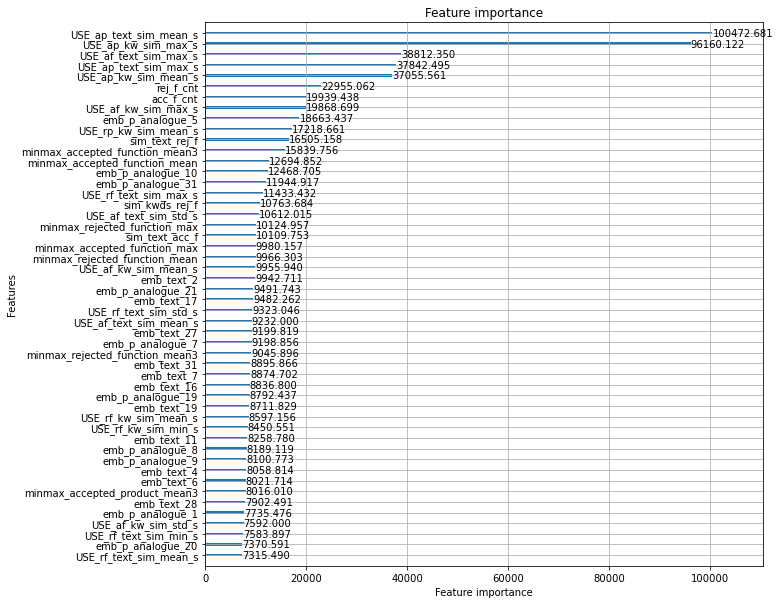

In [33]:
# plot importance for one of the OOF classifiers
plot_importance(classifier, max_num_features=50, figsize=(10,10), importance_type='gain')

### check whether label 0 is almost impossible in case rejected products are unspecified

In [34]:
pprint(
    df.loc[~df.is_test & ~df.rejected_product.astype(bool), TARGET].value_counts(normalize=True)
)

pprint(
    df.loc[~df.is_test & df.rejected_product.astype(bool), TARGET].value_counts(normalize=True)
)

1.0    0.802038
2.0    0.191647
0.0    0.006315
Name: target, dtype: float64
1.0    0.558395
0.0    0.256389
2.0    0.185216
Name: target, dtype: float64


### check accuracy on VAL (dev set, ~similar to LB by construction)

In [35]:
y_pred_val = np.round(classifier.predict(X_val))
y_pred_val_corrected = np.where(X_val.rej_p_is_empty & (y_pred_val == 0), 1, y_pred_val)

val_acc = np_weighted_accuracy(y_val, y_pred_val)
print(val_acc)
# 0.7269945355191256
# rerun 0.7184699453551913
# features0-2 0.7261202185792349
# max, mean, mean3 0.7302732240437159
# git pull 0.7441682600382409
# again, max, mean, mean3 0.752963671128107

# nope :(
print(np_weighted_accuracy(y_val, y_pred_val_corrected))

0.7502868068833652
0.7388145315487572


# Prepare submission

In [36]:
sample_submission = pd.read_csv(pjoin(DATA_DIR, 'sample_submission.csv')).set_index('id')
sample_submission.head()

target
id                                          
071c2e15-5fd0-4e7d-b78d-26b7c34491e1       1
e534df73-b385-4a12-8368-38992d3af7d3       1
4e38c9ff-bffe-4251-b2b2-94777c7344fe       1
a7f8870c-30f8-4851-8f8b-4c16942b397f       1
c062f411-ae3e-486a-9cba-2267889adb2b       1

In [41]:
# average class probabilities over OOF models and take argmax to obtain final class label
y_pred_raw = pred_test.mean(axis=-1)
print(y_pred_raw.shape)
y_test_pred = y_pred_raw.argmax(axis=1).astype(np.int32)

(4376, 3)


In [42]:
pprint(df.loc[~df.is_test.astype(bool), TARGET].value_counts(normalize=True))
pprint(pd.Series(y_test_pred).value_counts(normalize=True))

1.0    0.744892
2.0    0.190139
0.0    0.064969
Name: target, dtype: float64
1    0.795475
2    0.146938
0    0.057587
dtype: float64


In [51]:
# (deprecated)
# y_test_pred = classifier.predict(
#     df_features[df.is_test.astype(bool)].drop(columns=non_features)
# )

# add obtained class labels to sample_submission
sample_submission[TARGET] = y_test_pred

# save to .csv in submission dir
SUBM_DIR = pjoin('..', 'submissions')

w_part = 'with_sample_weight' if use_sample_weight else 'no_sample_weights'
subm_name = f'lightgbm_glove_USE_fasttext_{w_part}' + '_dev_cv={:.4f}.csv.gz'.format(TOTAL_SCORE)
subm_path = pjoin(SUBM_DIR, subm_name)
sample_submission.to_csv(subm_path, encoding='utf-8', compression='gzip')
print(f'submission was saved to {subm_path}')

# save raw predictions for blending
BLEND_DIR = pjoin('..', 'blending')
blend_path = pjoin(BLEND_DIR, subm_name[:-7] + '.npy')
print(f'raw predictions were saved to {blend_path}')
y_pred_raw.dump(blend_path)

submission was saved to ..\submissions\lightgbm_glove_USE_fasttext_with_sample_weight_dev_cv=0.7419.csv.gz
raw predictions were saved to ..\blending\lightgbm_glove_USE_fasttext_with_sample_weight_dev_cv=0.7419.npy
